In [1]:
import numpy as np
import time
from collections import namedtuple
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import qiskit as q
import qiskit.tools.jupyter
from qiskit.pulse import pulse_lib as _  # only want to call pulse_lib as q.pulse.pulse_lib

In [3]:
import pulse_compiler_helper_fns

In [4]:
q.IBMQ.load_account() # Load account from disk

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [5]:
#provider = q.IBMQ.get_provider(group='qiskit-terra', project='pulse-testing')
#backend = provider.get_backend('alt_almaden')
from qiskit.test.mock import FakeAlmaden
backend = FakeAlmaden()
defaults = backend.defaults()
circ_inst_map = defaults.circuit_instruction_map
measure = circ_inst_map.get('measure', qubits=backend.configuration().meas_map[0])

In [6]:
theta = np.pi / 2
phi = theta * 0.8752795188418716 / 1.8095454182113748
num_trotter_steps = 6

In [7]:
circuit = q.QuantumCircuit(2)
circuit.h(0); circuit.h(1);
for _ in range(num_trotter_steps):
    circuit.rz(theta, 0); circuit.rz(phi, 1);
    circuit.cx(0, 1); circuit.rz(theta, 1); circuit.cx(0, 1)  # ZZ Interaction
circuit.h(0); circuit.h(1);

In [8]:
schedules = []

transpiled_circuit = q.transpile(circuit, backend, optimization_level=1)
schedule = q.schedule(transpiled_circuit, backend=backend, inst_map=circ_inst_map)
schedule |= measure << schedule.duration
schedules.append(schedule)

qiskit.PULSE_BACKED_OPTIMIZATION = True
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import CommutationAnalysis, CommutativeCancellation, MatchZZInteraction
pm = PassManager()
pm.append([CommutationAnalysis(), MatchZZInteraction()])
matched_circuit = pm.run(circuit)
decomposed_circuit = matched_circuit.decompose()
pulse_compiler_helper_fns.update_basis_gates_and_circ_inst_map(decomposed_circuit, backend, circ_inst_map)
transpiled_circuit = q.transpile(decomposed_circuit, backend, optimization_level=1)
schedule = q.schedule(transpiled_circuit, backend=backend, inst_map=circ_inst_map)
schedule |= measure << schedule.duration
schedules.append(schedule)

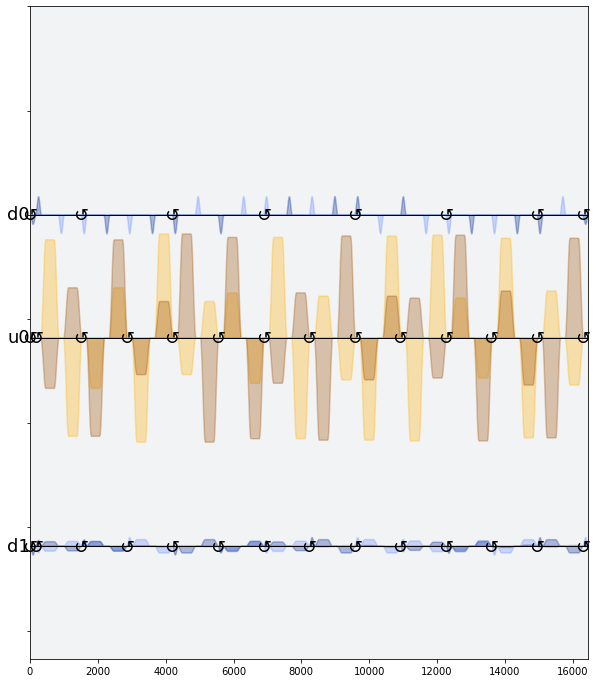

In [9]:
schedules[0].draw(channels=[
    backend.configuration().drive(0), backend.configuration().drive(1), backend.configuration().control(0)],
                 table=False)

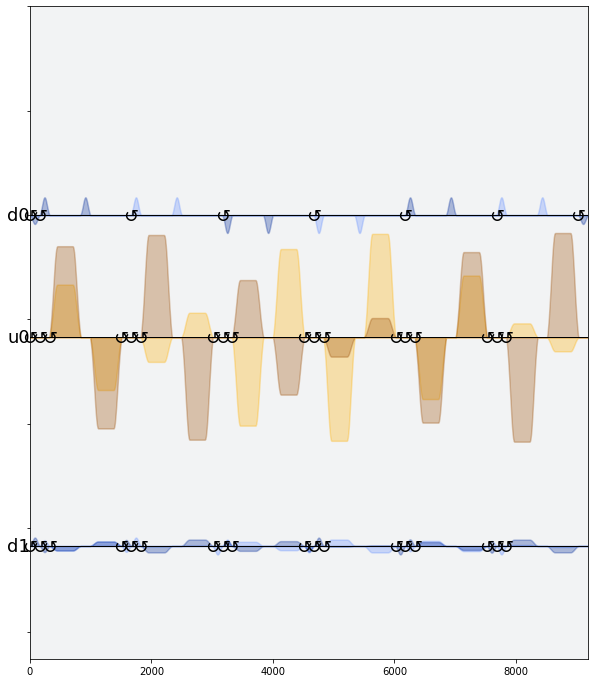

In [10]:
schedules[1].draw(channels=[
    backend.configuration().drive(0), backend.configuration().drive(1), backend.configuration().control(0)],
                 table=False)

In [ ]:
shots = 8000
job = q.execute(schedules, backend=backend, shots=shots)
print('job is %s' % job.job_id())

In [ ]:
job.status()

# Run a mitigation cal job

In [ ]:
import qiskit.ignis.mitigation.measurement as mit
meas_qcs, meas_labels = mit.complete_meas_cal(qubit_list=[0,1])
meas_qcs_transpiled = q.transpile(meas_qcs, backend, basis_gates=['x'])
meas_schedules = q.schedule(meas_qcs_transpiled, backend=backend, cmd_def=cmd_def)

In [ ]:
job_mit = q.execute(meas_schedules, backend, shots=shots)
print('job_mit is %s' % job_mit.job_id())

In [ ]:
job_mit.status()

-----
## Analysis

In [ ]:
from qiskit.result import marginal_counts

In [ ]:
result = job.result()

In [ ]:
# mitigate results
result_mit = marginal_counts(job_mit.result(), [0,1])
readout_fitter = mit.CompleteMeasFitter(result_mit, meas_labels)
readout_fitter.cal_matrix

In [ ]:
standard_counts = marginal_counts(result.get_counts(0), [0,1])
print('before mitigation:')
print(standard_counts)

standard_counts = readout_fitter.filter.apply(standard_counts)
print('\n\n\n after mitigation:')
print(standard_counts)

In [ ]:
optimized_counts = marginal_counts(result.get_counts(1), [0,1])
print('before mitigation:')
print(optimized_counts)

optimized_counts = readout_fitter.filter.apply(optimized_counts)
print('\n\n\n after mitigation:')
print(optimized_counts)

In [ ]:
# sanitize data and plot
for key in standard_counts:
    standard_counts[key] = int(standard_counts[key])
for key in optimized_counts:
    optimized_counts[key] = int(optimized_counts[key])

In [ ]:
standard_counts

In [ ]:
optimized_counts

In [ ]:
from qiskit.visualization import plot_histogram
plot_histogram([standard_counts, optimized_counts], legend=['standard', 'optimized'])

In [ ]:
ideal_counts = {'00': .576492*4000, '10': .423507*4000}  # https://algassert.com/quirk#circuit=%7B%22cols%22%3A%5B%5B%22H%22%2C%22H%22%5D%2C%5B%7B%22id%22%3A%22Rzft%22%2C%22arg%22%3A%22pi%2F2%22%7D%2C%7B%22id%22%3A%22Rzft%22%2C%22arg%22%3A%220.75980%22%7D%5D%2C%5B%5D%2C%5B%22%E2%80%A2%22%2C%22X%22%5D%2C%5B1%2C%7B%22id%22%3A%22Rzft%22%2C%22arg%22%3A%22pi%2F2%22%7D%5D%2C%5B%22%E2%80%A2%22%2C%22X%22%5D%2C%5B%7B%22id%22%3A%22Rzft%22%2C%22arg%22%3A%22pi%2F2%22%7D%2C%7B%22id%22%3A%22Rzft%22%2C%22arg%22%3A%220.75980%22%7D%5D%2C%5B%5D%2C%5B%22%E2%80%A2%22%2C%22X%22%5D%2C%5B1%2C%7B%22id%22%3A%22Rzft%22%2C%22arg%22%3A%22pi%2F2%22%7D%5D%2C%5B%22%E2%80%A2%22%2C%22X%22%5D%2C%5B1%2C%7B%22id%22%3A%22Rzft%22%2C%22arg%22%3A%220.75980%22%7D%5D%2C%5B%7B%22id%22%3A%22Rzft%22%2C%22arg%22%3A%22pi%2F2%22%7D%5D%2C%5B%22%E2%80%A2%22%2C%22X%22%5D%2C%5B1%2C%7B%22id%22%3A%22Rzft%22%2C%22arg%22%3A%22pi%2F2%22%7D%5D%2C%5B%22%E2%80%A2%22%2C%22X%22%5D%2C%5B%7B%22id%22%3A%22Rzft%22%2C%22arg%22%3A%22pi%2F2%22%7D%2C%7B%22id%22%3A%22Rzft%22%2C%22arg%22%3A%220.75980%22%7D%5D%2C%5B%5D%2C%5B%22%E2%80%A2%22%2C%22X%22%5D%2C%5B1%2C%7B%22id%22%3A%22Rzft%22%2C%22arg%22%3A%22pi%2F2%22%7D%5D%2C%5B%22%E2%80%A2%22%2C%22X%22%5D%2C%5B1%2C%7B%22id%22%3A%22Rzft%22%2C%22arg%22%3A%220.75980%22%7D%5D%2C%5B%7B%22id%22%3A%22Rzft%22%2C%22arg%22%3A%22pi%2F2%22%7D%5D%2C%5B%22%E2%80%A2%22%2C%22X%22%5D%2C%5B1%2C%7B%22id%22%3A%22Rzft%22%2C%22arg%22%3A%22pi%2F2%22%7D%5D%2C%5B%22%E2%80%A2%22%2C%22X%22%5D%2C%5B%7B%22id%22%3A%22Rzft%22%2C%22arg%22%3A%22pi%2F2%22%7D%2C%7B%22id%22%3A%22Rzft%22%2C%22arg%22%3A%220.75980%22%7D%5D%2C%5B%5D%2C%5B%22%E2%80%A2%22%2C%22X%22%5D%2C%5B1%2C%7B%22id%22%3A%22Rzft%22%2C%22arg%22%3A%22pi%2F2%22%7D%5D%2C%5B%22%E2%80%A2%22%2C%22X%22%5D%2C%5B%22H%22%2C%22H%22%5D%5D%7D
# standard_counts =
# optimized_counts = {'00': 3.2117147307346117e-09, '01': 4201.575210406215, '10': 3798.4247895903336, '11': 2.401224165590816e-10}

In [ ]:
print(pulse_compiler_helper_fns.kl_divergence(ideal_counts, standard_counts))
print(pulse_compiler_helper_fns.kl_divergence(ideal_counts, optimized_counts))

In [ ]:
print(pulse_compiler_helper_fns.cross_entropy(ideal_counts, standard_counts))
print(pulse_compiler_helper_fns.cross_entropy(ideal_counts, optimized_counts))

In [ ]:
from qiskit.quantum_info import hellinger_fidelity
print(hellinger_fidelity(ideal_counts, standard_counts))
print(hellinger_fidelity(ideal_counts, optimized_counts))